In [1]:
import datetime
import pytz
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd

from skyfield.api import Star, load, wgs84
from skyfield.data import hipparcos, stellarium
from skyfield.projections import build_stereographic_projection

# Datasets

In [2]:
eph = load('de440.bsp')

with load.open(hipparcos.URL) as f:
    stars = hipparcos.load_dataframe(f)

url = 'https://raw.githubusercontent.com/Stellarium/stellarium/master/skycultures/modern_st/constellationship.fab'
with load.open(url) as f:
    constellations = stellarium.parse_constellations(f)


In [3]:
stars.head()

,magnitude,ra_degrees,dec_degrees,parallax_mas,ra_mas_per_year,dec_mas_per_year,ra_hours,epoch_year
hip,,,,,,,,
1,9.10,0.000912,1.089013,3.54,-5.20,-1.88,0.000061,1991.25
2,9.27,0.003797,-19.498837,21.90,181.21,-0.93,0.000253,1991.25
3,6.61,0.005008,38.859286,2.81,5.24,-2.91,0.000334,1991.25
4,8.06,0.008382,-51.893546,7.75,62.85,0.16,0.000559,1991.25
5,8.55,0.009965,-40.591224,2.87,2.53,9.07,0.000664,1991.25


# Time and location

Time is 20th August, 00:00. I got the right latitude and longitude from Google maps:

<img src="./imgs/location.png" alt="location" width="800"/>

In [4]:
# Location
latitude, longitude = 47.639483, 11.348130 # from Google Maps

# Time
d = datetime.datetime(2023, 8, 20, 0, 0, 0)
tz = pytz.timezone('Europe/Berlin')
time = tz.localize(d)
time_utc = time.astimezone(pytz.timezone('UTC'))

ts = load.timescale()
t = ts.from_datetime(time_utc)

# Stars location relative to observer

In [5]:
earth = eph['earth']
sun = eph['sun']

observer = wgs84.latlon(latitude_degrees=latitude, longitude_degrees=longitude).at(t)
# position = observer.from_altaz(alt_degrees=90, az_degrees=45)

ra, dec, distance = observer.radec()
center_star = Star(ra=ra, dec=dec)
center = earth.at(t).observe(center_star)
projection = build_stereographic_projection(center)
star_positions = earth.at(t).observe(Star.from_dataframe(stars))

stars['x'], stars['y'] = projection(star_positions)

# Constellations edges

In [6]:
edges = [edge for name, edges in constellations for edge in edges]
edges_star1 = [star1 for star1, star2 in edges]
edges_star2 = [star2 for star1, star2 in edges]
xy1 = stars[['x', 'y']].loc[edges_star1].values
xy2 = stars[['x', 'y']].loc[edges_star2].values
lines_xy = np.rollaxis(np.array([xy1, xy2]), 1)

# Plotting

In [7]:
max_size = 100
magnitude = stars['magnitude']
marker_size = max_size * 10 ** (magnitude/-2.5)

In [8]:
cm = 0.39370079 # inch
size_in = 10 * cm
dpi = 500
display_dpi=200

stars_colour = '#D9C791'
bg_colour = '#010F21' #'#011126' #'#011126'
constallation_colour = '#8AB0BF'

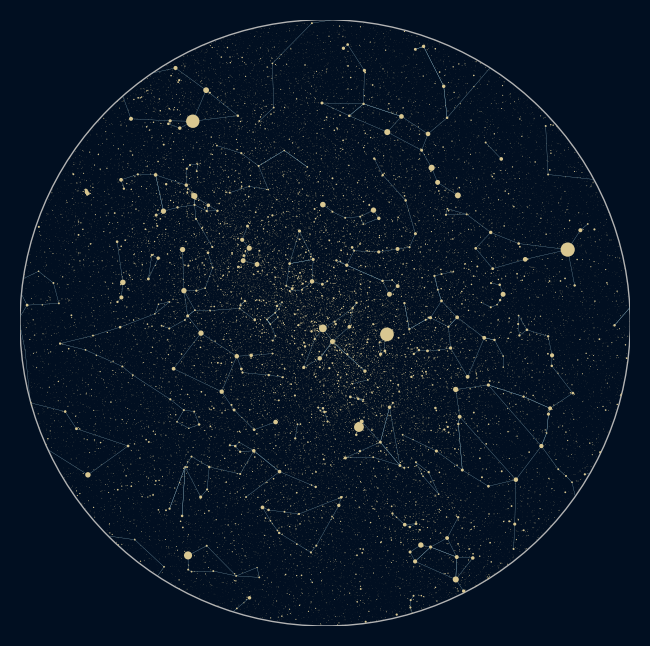

In [9]:
fig, ax = plt.subplots(1,1, figsize=(size_in,size_in), dpi=display_dpi)
fig.patch.set_facecolor(bg_colour) ##0B0B33

ax.add_collection(mpl.collections.LineCollection(lines_xy, colors=constallation_colour, linewidths=0.1))
ax.scatter(stars['x'], stars['y'], s=marker_size, marker='.', color=stars_colour, linewidth=0, zorder=3)

horizon = plt.Circle((0, 0), radius=1, transform=ax.transData, color='.7', fill=False, linewidth=0.5)
ax.add_patch(horizon)
for col in ax.collections:
    col.set_clip_path(horizon)

ax.set_xlim(-1, 1)
ax.set_ylim(-1, 1)
ax.axis('off')

fig.savefig('./imgs/stars.png', dpi=dpi)

# Plot elements separately

In [10]:
small_stars = stars[marker_size < 0.5]
small_stars_s = marker_size[marker_size < 0.5]

big_stars = stars[marker_size > 0.5]
big_stars_s = marker_size[marker_size > 0.5]

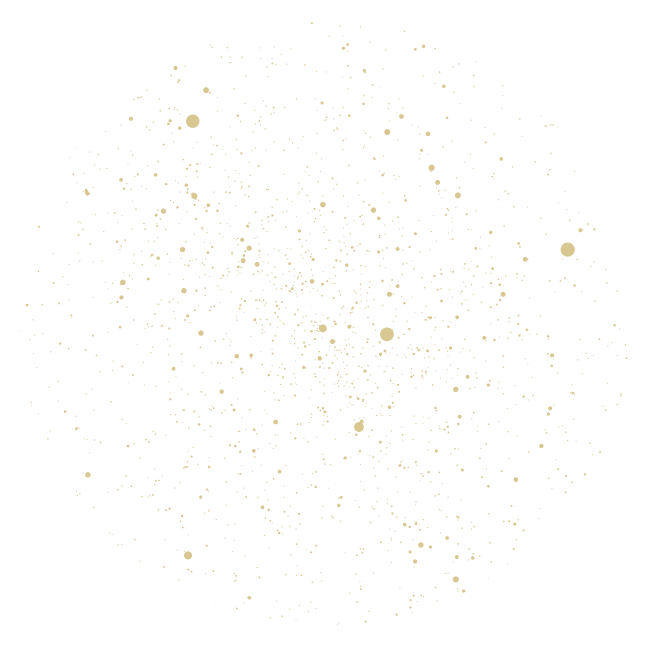

In [11]:
fig, ax = plt.subplots(1,1, figsize=(size_in,size_in), dpi=display_dpi)
ax.scatter(big_stars['x'], big_stars['y'], s=big_stars_s, marker='.', color=stars_colour, linewidth=0, zorder=3)
horizon = plt.Circle((0, 0), radius=1, transform=ax.transData, color='.7', fill=False, linewidth=0.5)
for col in ax.collections:
    col.set_clip_path(horizon)

ax.set_xlim(-1, 1)
ax.set_ylim(-1, 1)
ax.axis('off')

fig.savefig('./imgs/big-stars.png', dpi=dpi, transparent=True)

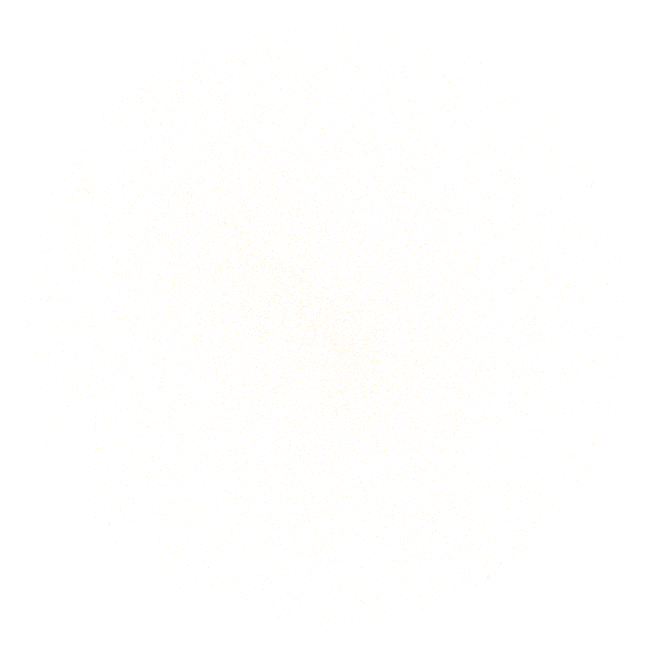

In [12]:
fig, ax = plt.subplots(1,1, figsize=(size_in,size_in), dpi=display_dpi)
ax.scatter(small_stars['x'], small_stars['y'], s=small_stars_s, marker='.', color='#FFEAAB', linewidth=0, zorder=3)
horizon = plt.Circle((0, 0), radius=1, transform=ax.transData, color='.7', fill=False, linewidth=0.5)
for col in ax.collections:
    col.set_clip_path(horizon)

ax.set_xlim(-1, 1)
ax.set_ylim(-1, 1)
ax.axis('off')

fig.savefig('./imgs/small-stars.png', dpi=dpi, transparent=True)

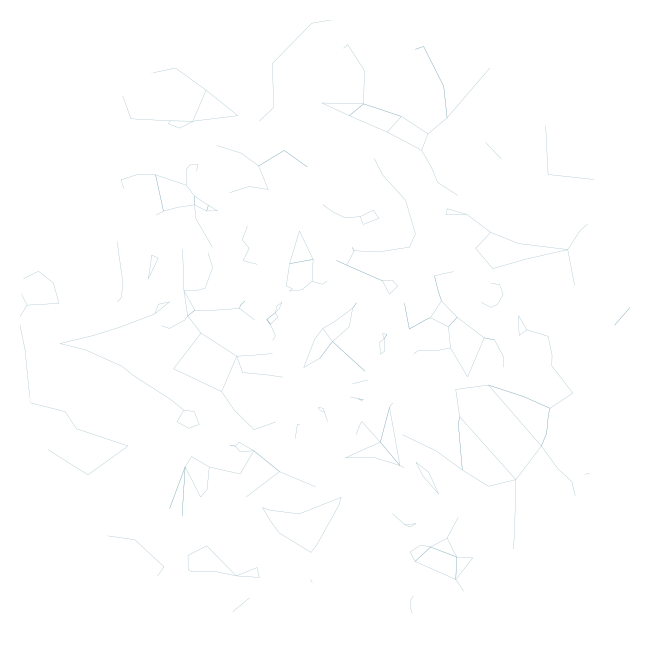

In [13]:
fig, ax = plt.subplots(1,1, figsize=(size_in,size_in), dpi=display_dpi)
ax.add_collection(mpl.collections.LineCollection(lines_xy, colors=constallation_colour, linewidths=0.1))
horizon = plt.Circle((0, 0), radius=1, transform=ax.transData, color='.7', fill=False, linewidth=0.5)
for col in ax.collections:
    col.set_clip_path(horizon)

ax.set_xlim(-1, 1)
ax.set_ylim(-1, 1)
ax.axis('off')

fig.savefig('./imgs/constellations.png', dpi=dpi, transparent=True)

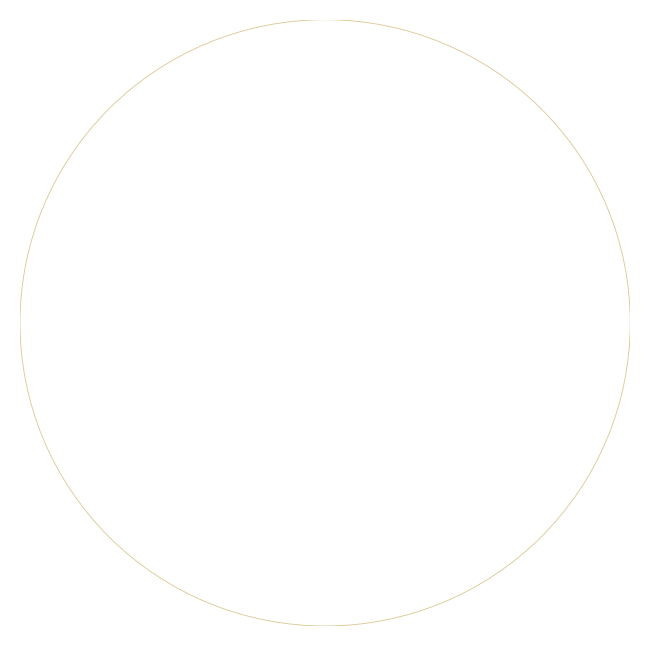

In [14]:
fig, ax = plt.subplots(1,1, figsize=(size_in,size_in), dpi=display_dpi)
horizon = plt.Circle((0, 0), radius=1, transform=ax.transData, color=stars_colour, fill=False, linewidth=0.3)
ax.add_patch(horizon)

ax.set_xlim(-1, 1)
ax.set_ylim(-1, 1)
ax.axis('off')

fig.savefig('./imgs/horizon.png', dpi=dpi, transparent=True)

# Calculate viewing angle

When you're lying down, what appears on top or "north" is acrually the south and vice versa

<img src="./imgs/gaze-dir.png" alt="gaze" width="500"/>

In [15]:
height = 472 # px
width = 605 # px

hypotenuse = np.sqrt(height**2 + width**2)
angle = np.arcsin(width / hypotenuse)

print(180+np.degrees(angle))

232.0398815237216


# Sources
- https://viyaleta.medium.com/how-to-make-a-sky-map-in-python-a362bf722bb2
- https://levelup.gitconnected.com/how-to-use-python-to-create-custom-star-maps-for-your-next-stargazing-journey-9908b421f30e
